# 배터리 잔여 수명(RUL) 예측을 위한 1D CNN 모델링

**작성자: GitHub Copilot**

이 노트북은 PyTorch와 1D CNN(Convolutional Neural Network)을 사용하여 배터리의 잔여 수명(RUL, Remaining Useful Life)을 예측하는 과정을 담고 있습니다. 데이터 전처리부터 모델 구축, 학습, 평가까지의 전체 파이프라인을 체계적으로 안내합니다.

## 1. 필요 라이브러리 임포트 및 환경 설정

분석에 필요한 라이브러리를 임포트하고, GPU 사용 여부 등 학습 환경을 설정합니다.

In [39]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# 시각화 스타일 설정
sns.set_style('whitegrid')
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## 2. 데이터 로드 및 탐색 (특정 배터리 선정)

`metadata.csv` 파일을 로드하여 전체 데이터셋의 구조를 파악하고, 분석할 배터리를 선정합니다.

In [40]:
# 데이터 경로 설정
metadata_path = 'cleaned_dataset/metadata.csv'
data_path = 'cleaned_dataset/data/'

# 메타데이터 로드
metadata_df = pd.read_csv(metadata_path)

# 데이터셋 정보 확인
print("### 메타데이터 정보 ###")
metadata_df.info()

print("\n### 메타데이터 상위 5개 행 ###")
print(metadata_df.head())

# 배터리별 사이클 수 확인
battery_cycle_counts = metadata_df['battery_id'].value_counts()
print("\n### 배터리별 사이클 수 ###")
print(battery_cycle_counts)

# 사이클 수가 가장 많은 배터리 선정 (혹은 특정 배터리 B0006)
# 여기서는 B0006 배터리를 대상으로 분석을 진행하겠습니다.
TARGET_BATTERY = 'B0006'
print(f"\n분석 대상 배터리: {TARGET_BATTERY}")

### 메타데이터 정보 ###
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7565 entries, 0 to 7564
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   type                 7565 non-null   object
 1   start_time           7565 non-null   object
 2   ambient_temperature  7565 non-null   int64 
 3   battery_id           7565 non-null   object
 4   test_id              7565 non-null   int64 
 5   uid                  7565 non-null   int64 
 6   filename             7565 non-null   object
 7   Capacity             2794 non-null   object
 8   Re                   1956 non-null   object
 9   Rct                  1956 non-null   object
dtypes: int64(3), object(7)
memory usage: 591.1+ KB

### 메타데이터 상위 5개 행 ###
        type                                         start_time  \
0  discharge  [2010.       7.      21.      15.       0.    ...   
1  impedance  [2010.       7.      21.      16.      53.    ...   
2     charge

## 3. 데이터 전처리 및 RUL(잔여 수명) 계산

선정한 배터리의 사이클 별 용량(Capacity) 변화를 시각화하여 열화 경향을 확인하고, 잔여 수명(RUL)을 계산합니다.

C:\Users\daeho\AppData\Local\Temp\ipykernel_10752\4097197581.py:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  battery_df['Capacity'] = battery_df['Capacity'].fillna(method='ffill')


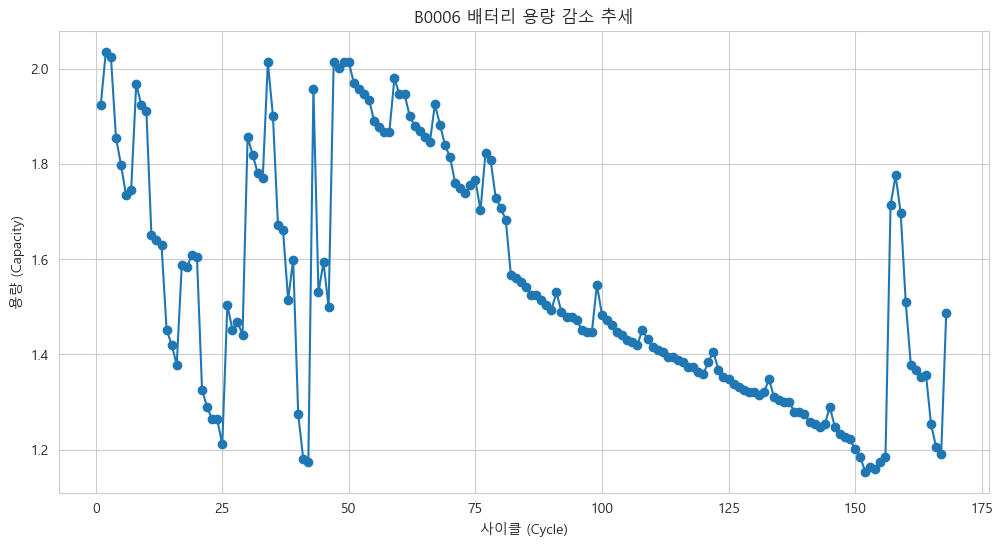

수명 종료(EOL) 사이클: 14

### RUL이 추가된 데이터프레임 ###
   cycle  Capacity  RUL
0      1  1.924246   13
1      2  2.035338   12
2      3  2.025140   11
3      4  1.855277   10
4      5  1.797102    9


In [41]:
# 특정 배터리의 방전 데이터만 필터링
battery_df = metadata_df[(metadata_df['battery_id'] == TARGET_BATTERY) & (metadata_df['type'] == 'discharge')].copy()
battery_df = battery_df.sort_values(by='start_time').reset_index(drop=True)

# Capacity 열을 숫자형으로 변환
battery_df['Capacity'] = pd.to_numeric(battery_df['Capacity'], errors='coerce')

# 사이클 번호 추가
battery_df['cycle'] = range(1, len(battery_df) + 1)

# 용량(Capacity) 결측치 처리 (0인 경우 이전 값으로 채우기)
battery_df['Capacity'] = battery_df['Capacity'].replace(0, np.nan)
battery_df['Capacity'] = battery_df['Capacity'].fillna(method='ffill')

# 용량 변화 시각화
plt.figure(figsize=(12, 6))
plt.plot(battery_df['cycle'], battery_df['Capacity'], marker='o', linestyle='-')
plt.title(f'{TARGET_BATTERY} 배터리 용량 감소 추세')
plt.xlabel('사이클 (Cycle)')
plt.ylabel('용량 (Capacity)')
plt.grid(True)
plt.show()

# RUL 계산
initial_capacity = battery_df['Capacity'].iloc[0]
eol_threshold = initial_capacity * 0.8  # 공칭 용량의 80%를 수명 종료 기준으로 설정

# 수명이 다한 사이클 찾기
eol_cycle = battery_df[battery_df['Capacity'] <= eol_threshold]['cycle'].min()

if pd.isna(eol_cycle):
    print("배터리 수명이 임계값 이하로 떨어지지 않았습니다. 전체 사이클을 사용합니다.")
    battery_df['RUL'] = len(battery_df) - battery_df['cycle']
else:
    print(f"수명 종료(EOL) 사이클: {eol_cycle}")
    # 수명이 다한 이후 데이터는 제외
    battery_df = battery_df[battery_df['cycle'] <= eol_cycle].copy()
    battery_df['RUL'] = eol_cycle - battery_df['cycle']

print("\n### RUL이 추가된 데이터프레임 ###")
print(battery_df[['cycle', 'Capacity', 'RUL']].head())

## 4. 시퀀스 데이터 생성 및 데이터셋 분할

1D CNN 모델의 입력으로 사용하기 위해 방전 프로파일(전압, 전류, 온도 등)을 고정된 길이의 시퀀스 데이터로 변환하고, 데이터셋을 분할합니다.

In [42]:
# 모든 사이클의 시계열 데이터를 하나의 리스트로 로드
cycle_data_list = []
for filename in battery_df['filename']:
    file_path = os.path.join(data_path, filename)
    df = pd.read_csv(file_path)
    cycle_data_list.append(df[['Voltage_measured', 'Current_measured', 'Temperature_measured']].values)

# 시퀀스 길이 통일 (가장 짧은 길이에 맞추거나, padding/truncating)
min_len = min(len(d) for d in cycle_data_list)
cycle_data_list = [d[:min_len] for d in cycle_data_list]

# (num_cycles, sequence_length, num_features) 형태로 변환
data_np = np.array(cycle_data_list)
print(f"데이터 형태: {data_np.shape}")

# 데이터 정규화
scaler = MinMaxScaler()
num_cycles, seq_len, num_features = data_np.shape
data_np = data_np.reshape(-1, num_features)
data_np = scaler.fit_transform(data_np)
data_np = data_np.reshape(num_cycles, seq_len, num_features)

# Sliding Window를 사용하여 시퀀스 데이터 생성
def create_sequences(data, rul_data, window_size):
    sequences = []
    labels = []
    for i in range(len(data) - window_size):
        sequences.append(data[i:i+window_size])
        labels.append(rul_data[i+window_size-1])
    return np.array(sequences), np.array(labels)

WINDOW_SIZE = 10
X, y = create_sequences(data_np, battery_df['RUL'].values, WINDOW_SIZE)

# (num_samples, window_size, sequence_length, num_features) -> (num_samples, num_features, window_size * sequence_length)
# 1D CNN은 (N, C_in, L_in) 형태의 입력을 기대합니다.
# 여기서는 특징(feature)을 채널로, 시계열 데이터를 길이로 사용합니다.
# (num_samples, window_size, seq_len, num_features) -> (num_samples, num_features, window_size, seq_len)
X = X.transpose(0, 3, 1, 2)
# (num_samples, num_features, window_size * seq_len)
X = X.reshape(X.shape[0], X.shape[1], -1)


print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")


# 데이터셋 분할 (Train, Validation, Test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

데이터 형태: (14, 186, 3)
X shape: (4, 3, 1860)
y shape: (4,)
Train set: (2, 3, 1860), (2,)
Validation set: (1, 3, 1860), (1,)
Test set: (1, 3, 1860), (1,)


## 5. PyTorch Dataset 및 DataLoader 생성

PyTorch의 `Dataset` 클래스를 상속받아 커스텀 데이터셋을 정의하고, `DataLoader`를 생성하여 미니배치 학습을 준비합니다.

In [43]:
class BatteryDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# 데이터셋 및 데이터로더 생성
BATCH_SIZE = 8

train_dataset = BatteryDataset(X_train, y_train)
val_dataset = BatteryDataset(X_val, y_val)
test_dataset = BatteryDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train loader batches: {len(train_loader)}")
print(f"Validation loader batches: {len(val_loader)}")
print(f"Test loader batches: {len(test_loader)}")

Train loader batches: 1
Validation loader batches: 1
Test loader batches: 1


## 6. 1D CNN 모델 정의

`torch.nn.Module`을 사용하여 1D CNN 모델 아키텍처를 정의합니다. 이 모델은 시계열 데이터로부터 특징을 추출하고 RUL을 예측합니다.

In [44]:
class CNN1D(nn.Module):
    def __init__(self, input_channels, seq_len):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        # Flatten 후의 크기 계산
        self.flatten_size = 32 * (seq_len // 4)
        
        self.fc1 = nn.Linear(self.flatten_size, 50)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, self.flatten_size) # Flatten
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x

# 모델 인스턴스 생성
input_channels = X_train.shape[1]
seq_len = X_train.shape[2]
model = CNN1D(input_channels, seq_len).to(device)

print(model)

CNN1D(
  (conv1): Conv1d(3, 16, kernel_size=(5,), stride=(1,), padding=(2,))
  (relu1): ReLU()
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (relu2): ReLU()
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=14880, out_features=50, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=50, out_features=1, bias=True)
)


## 7. 모델 학습

손실 함수와 옵티마이저를 정의하고, 훈련 루프를 구현하여 모델을 학습시킵니다.

Epoch 1/100, Train Loss: 10.1275, Val Loss: 4.1365
Best model saved.
Epoch 2/100, Train Loss: 5.1209, Val Loss: 0.8863
Best model saved.
Epoch 3/100, Train Loss: 1.8363, Val Loss: 0.1035
Best model saved.
Epoch 4/100, Train Loss: 0.9980, Val Loss: 1.7526
Epoch 5/100, Train Loss: 2.5745, Val Loss: 2.2709
Epoch 6/100, Train Loss: 3.0525, Val Loss: 1.5152
Epoch 7/100, Train Loss: 2.2832, Val Loss: 0.5824
Epoch 8/100, Train Loss: 1.3507, Val Loss: 0.0725
Epoch 5/100, Train Loss: 2.5745, Val Loss: 2.2709
Epoch 6/100, Train Loss: 3.0525, Val Loss: 1.5152
Epoch 7/100, Train Loss: 2.2832, Val Loss: 0.5824
Epoch 8/100, Train Loss: 1.3507, Val Loss: 0.0725
Best model saved.
Epoch 9/100, Train Loss: 0.8459, Val Loss: 0.0244
Best model saved.
Epoch 10/100, Train Loss: 0.7996, Val Loss: 0.2248
Best model saved.
Epoch 9/100, Train Loss: 0.8459, Val Loss: 0.0244
Best model saved.
Epoch 10/100, Train Loss: 0.7996, Val Loss: 0.2248
Epoch 11/100, Train Loss: 0.9964, Val Loss: 0.4626
Epoch 12/100, Train 

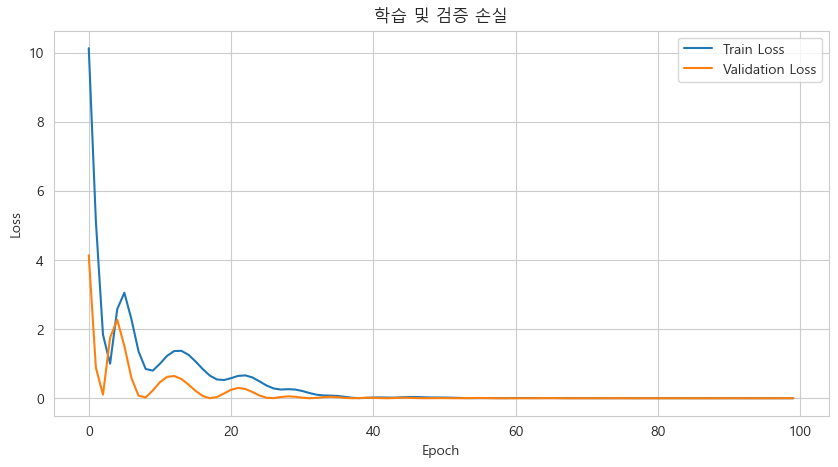

In [45]:
# 손실 함수 및 옵티마이저 정의
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 학습 파라미터
NUM_EPOCHS = 100
best_val_loss = float('inf')
train_losses = []
val_losses = []

# 학습 루프
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(features)
        loss = criterion(outputs, labels.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * features.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    
    # 검증
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for features, labels in val_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            loss = criterion(outputs, labels.unsqueeze(1))
            val_loss += loss.item() * features.size(0)
            
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    # 최고 성능 모델 저장
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print("Best model saved.")

# 학습 과정 시각화
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('학습 및 검증 손실')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 8. 모델 평가 및 결과 시각화

학습된 모델을 사용하여 테스트 데이터셋의 RUL을 예측하고, 실제 값과 비교하여 모델의 성능을 평가합니다.

Test RMSE: 0.8471


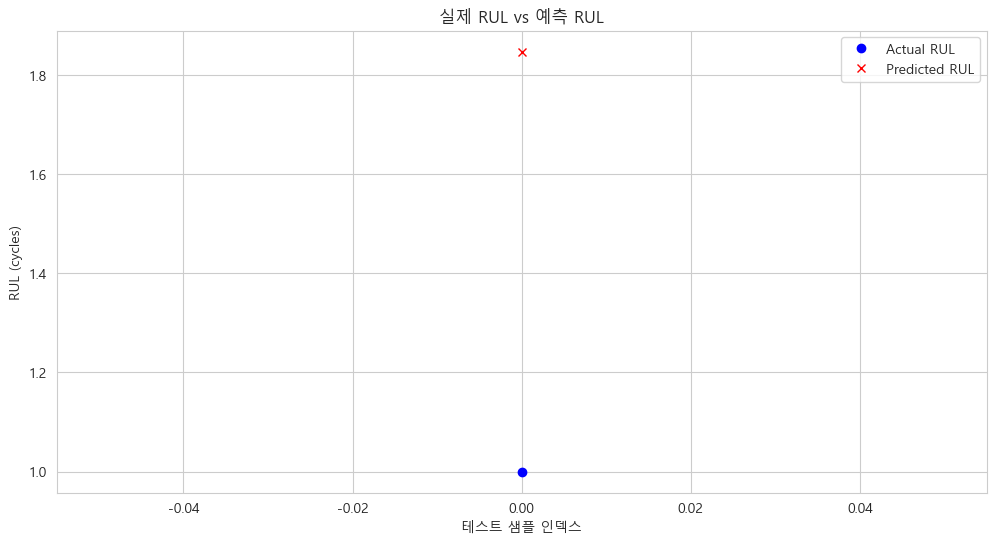

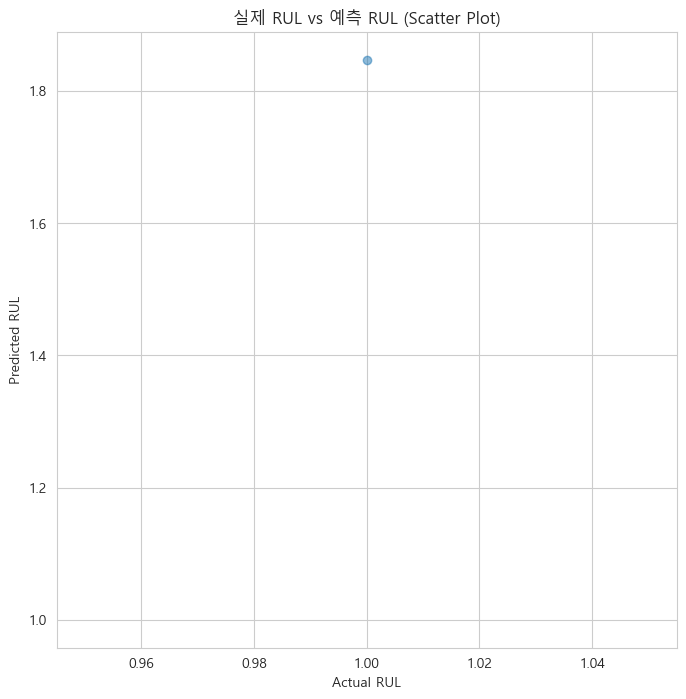


### 1개 샘플에 대한 상세 예측 결과 ###
샘플 1 (인덱스: 0):
  - 실제 RUL: 1.00
  - 예측 RUL: 1.85
  - 오차: 0.85


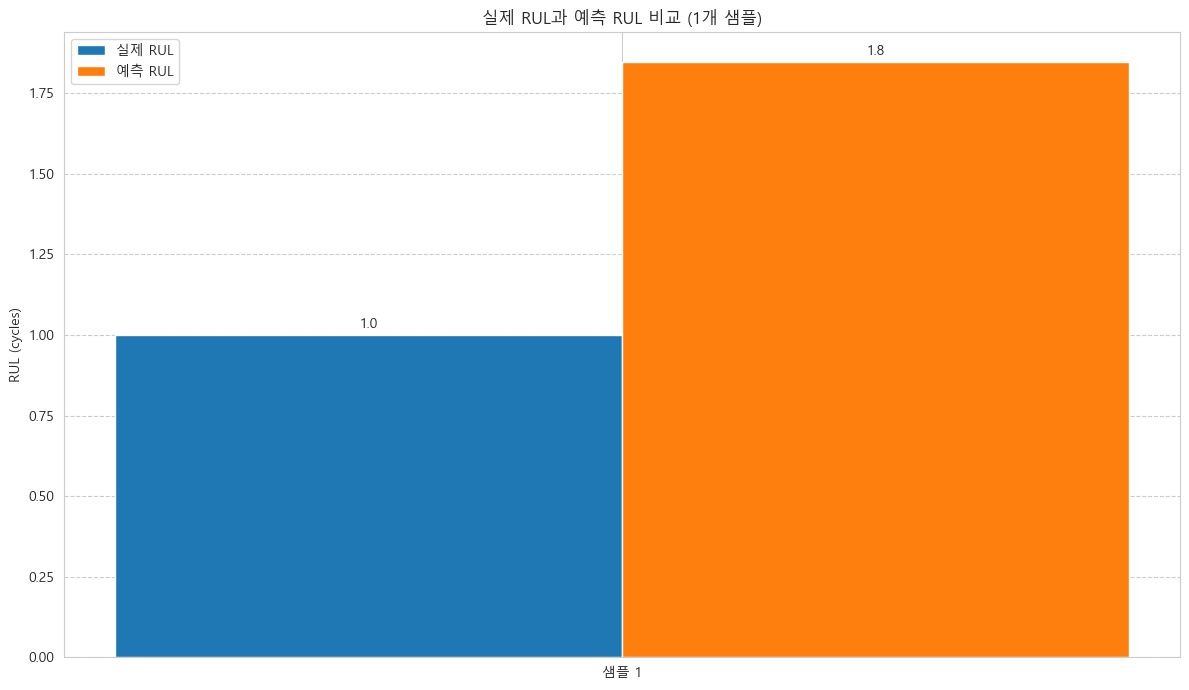

In [ ]:
# 최고 성능 모델 로드
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# 예측
predictions = []
actuals = []
with torch.no_grad():
    for features, labels in test_loader:
        features = features.to(device)
        outputs = model(features)
        predictions.extend(outputs.cpu().numpy())
        actuals.extend(labels.numpy())

predictions = np.array(predictions).flatten()
actuals = np.array(actuals).flatten()

# 성능 평가 (RMSE)
rmse = np.sqrt(np.mean((predictions - actuals)**2))
print(f"Test RMSE: {rmse:.4f}")

# 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(actuals, label='Actual RUL', color='blue', marker='o', linestyle='')
plt.plot(predictions, label='Predicted RUL', color='red', marker='x', linestyle='')
plt.title('실제 RUL vs 예측 RUL')
plt.xlabel('테스트 샘플 인덱스')
plt.ylabel('RUL (cycles)')
plt.legend()
plt.show()

# Scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(actuals, predictions, alpha=0.5)
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'r--')
plt.title('실제 RUL vs 예측 RUL (Scatter Plot)')
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.grid(True)
plt.show()
